In [1]:
import fair
from fair.unit_def import unit

from fair.species import GreenhouseGas, CO2, CH4, N2O
from fair.forcing.ghg import etminan

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

In [2]:
def populate_gas_defaults(*requested_gases):
    """Fills in the scenario with specified gases.
    
    Args:
        requested_gases: optional list of gases. If omitted, use all CMIP6 specified gases.
    """
    gas_defaults = pd.read_csv('../fair/data/gas_defaults.csv')

    gases = {}
    if len(requested_gases)==0:
        requested_gases=tuple(gas_defaults['name'])
    elif len(requested_gases)==1 and isinstance(requested_gases[0], list):
        requested_gases=tuple(requested_gases[0])

    ref_unit_lookup = {
        'ppm' : unit.ppm,
        'ppb' : unit.ppb,
        'ppt' : unit.ppt
    }
        
    for index, gas in gas_defaults.iterrows():
        if gas['name'] not in requested_gases:
            continue
        if gas['name'] not in ['CO2', 'CH4', 'N2O', 'CFC-12-eq', 'CFC-11-eq', 'HFC-134a-eq']:
            gases[gas['name']] = GreenhouseGas(
                radiative_efficiency=gas['radiative_efficiency_W_m-2_ppb-1'] * unit.watt / unit.m**2 / unit.ppb,
                reference_concentration=gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                concentration_t0=0 * gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                molecular_weight=gas['molecular_weight_g_mol-1'] * unit.g / unit.mol,
                lifetime=gas['lifetime_yr'] * unit.year,
                name=gas['name']
            )
        elif gas['name']=='CO2':
            gases[gas['name']] = CO2(
                radiative_efficiency=gas['radiative_efficiency_W_m-2_ppb-1'] * unit.watt / unit.m**2 / unit.ppb,
                reference_concentration=gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                concentration_t0=0 * gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                molecular_weight=gas['molecular_weight_g_mol-1'] * unit.g / unit.mol,
                lifetime=gas['lifetime_yr'] * unit.year,
                name=gas['name'],
                a=np.array([0.217300, 0.224000, 0.282400, 0.276300]),
                tau=np.array([1000000.000000, 394.400000, 36.540000, 4.304000])*unit.year,
                r0=28.627296 * unit.year,
                rC=0.019773 * unit.year / unit.Gt,
                rT=4.334433 * unit.year / unit.K,
            )
        elif gas['name']=='CH4':
            gases[gas['name']] = CH4(
                radiative_efficiency=gas['radiative_efficiency_W_m-2_ppb-1'] * unit.watt / unit.m**2 / unit.ppb,
                reference_concentration=gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                concentration_t0=0 * gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                molecular_weight=gas['molecular_weight_g_mol-1'] * unit.g / unit.mol,
                lifetime=gas['lifetime_yr'] * unit.year,
                name=gas['name']
            )
        elif gas['name']=='N2O':
            gases[gas['name']] = N2O(
                radiative_efficiency=gas['radiative_efficiency_W_m-2_ppb-1'] * unit.watt / unit.m**2 / unit.ppb,
                reference_concentration=gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                concentration_t0=0 * gas['reference_concentration'] * ref_unit_lookup[gas['reference_concentration_unit']],
                molecular_weight=gas['molecular_weight_g_mol-1'] * unit.g / unit.mol,
                lifetime=gas['lifetime_yr'] * unit.year,
                name=gas['name']
            )
    return gases

In [5]:
gases = populate_gas_defaults(['CFC-12','CO2','CH4','N2O'])
gases['CO2'].set_concentrations(np.linspace(278,415,1001) * unit.ppm)
gases['N2O'].set_concentrations(np.linspace(272,500,1001) * unit.ppb)
gases['CH4'].set_concentrations(np.linspace(791,1800,1001) * unit.ppb)
gases['CFC-12'].set_emissions(np.ones(1000)*500 * unit.kt / unit.year, natural = 0.00 * unit.kt / unit.year)
gases['CFC-12'].set_lifetime(67 * unit.years)
gases['CFC-12'].calculate_concentrations()
gases

{'CO2': <fair.species.species.CO2 at 0x7f1221bfa450>,
 'CH4': <fair.species.species.CH4 at 0x7f1221bf85d0>,
 'N2O': <fair.species.species.N2O at 0x7f1221bfaa10>,
 'CFC-12': <fair.species.species.GreenhouseGas at 0x7f1221bfab90>}

/nfs/b0110/Users/mencsm/miniconda3/envs/openscm-graft/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


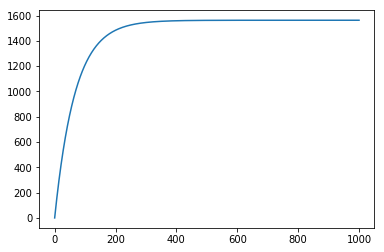

In [6]:
pl.plot(gases['CFC-12'].time_bounds, gases['CFC-12'].concentrations.to('ppt'))

In [8]:
class Scenario:    # I think this should probably be the base class - build Species off this, and then GHG, Aerosol etc
    
    def __init__(self, *args, start=1750*unit.year, end=2500*unit.year, temperature_t0=0*unit.K, timestep=1*unit.year):
        self.species = {}
        self.add_species(*args)
        self.temperature_t0 = temperature_t0
        self.timestep = timestep
        self.nt = int((end-start)/timestep)+1
        self.temperature = np.ones(self.nt) * np.nan * unit.K 
        self.temperature[0] = self.temperature_t0
        
    def add_species(self, *args):
        for arg in args:
            for key, value in arg.items():
                self.species[key] = value
                
 
    def calculate_forcing(self):
        co2 = self.species['CO2']
        ch4 = self.species['CH4']
        n2o = self.species['N2O']
        for species in self.species:
            if type(self.species[species]) not in [CO2,CH4,N2O]:
                self.species[species].calculate_forcing()
        etminan(co2, ch4, n2o)
        self.effective_radiative_forcing = (sum([v.effective_radiative_forcing for v in self.species.values()]))
        
        
    def calculate_temperature(self, method='Millar'):
        """Calculate temperature from a given radiative forcing.
        Inputs:
            t0: Temperature in timestep t-1
            q: The matrix contributions to slow and fast temperature change
               calculated from ECS and TCR (2 element array)
            d: The slow and fast thermal response time constants (2 element array)
            f: radiative forcing (can be scalar or 1D array representing multiple
           species)
        Keywords:
            e: efficacy factor (default 1); if f is an array, e should be an array
               of the same length.
        Outputs:
            t1: slow and fast contributions to total temperature (2 element array)
            in timestep t
        """
        def _forward(t0, q, d, f, ts, e=1):
            t1 = t0*np.exp(-ts/d) + q*(1.0-np.exp((-ts)/d))*np.sum(f*e)#*ts
            return t1

        q = self._calculate_q()
        nbox = len(q)
        T_j = np.ones((nt, nbox)) * np.nan * unit.K
        d=np.array([239, 4.1]) * unit.year
        
        T_j[0,:] = self.temperature_t0 # won't be true for restarts
        
        for t in range(nt-1):
            T_j[t+1,:] = _forward(T_j[t,:], q, d, effective_radiative_forcing[t], self.timestep)

        self.temperature = np.sum(T_j, axis=1)
        
    
    def _calculate_q(self, tcr=1.75*unit.K, ecs=3*unit.K, d=np.array([239, 4.1]) * unit.year, f2x=4.00 * unit.W / unit.m**2, tcr_dbl=70 * unit.year):
        
        # TODO: GIR multi-box version
        # for now this follows FaIR 1.5
        
        """If TCR and ECS are supplied, calculate the q model coefficients.
        See Eqs. (4) and (5) of Millar et al ACP (2017).

        Inputs:
            tcrecs  : 2-element array of transient climate response (TCR) and
                      equilibrium climate sensitivity (ECS).
            d       : The slow and fast thermal response time constants
            f2x     : Effective radiative forcing from a doubling of CO2
            tcr_dbl : time to a doubling of CO2 under 1% per year CO2 increase, yr
            nt      : number of timesteps

        Outputs:
            q       : coefficients of slow and fast temperature change in each
                      timestep ((nt, 2) array).
        """
        
        mat = np.ones(2) * np.nan * unit.K       
        k = 1.0 - (d/tcr_dbl)*(1.0 - np.exp(-tcr_dbl/d))
        mat[0] = tcr-ecs*k[1]
        mat[1] = ecs*k[0]-tcr
        
        q  = (1.0 / f2x) * (1.0/(k[0]-k[1])) * mat
        return q
    
    def forward(self): 
        for t in range(self.nt-1):
            for species in self.species:
#            if not hasattr(self.species[species], 'concentrations'):
                self.species[species].calculate_concentrations()
            self.calculate_forcing(t)
            self.calculate_temperature(method='Millar')

In [9]:
#del scen
scen = Scenario(gases)
#scen.forward()

In [10]:
scen.calculate_forcing()

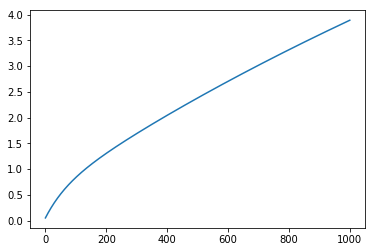

In [11]:
pl.plot(scen.effective_radiative_forcing)

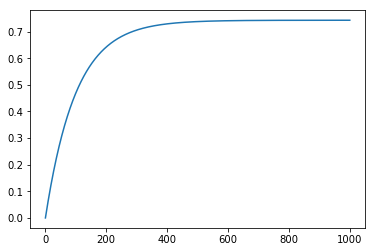

In [18]:
pl.plot(gases['CFC-12'].effective_radiative_forcing)

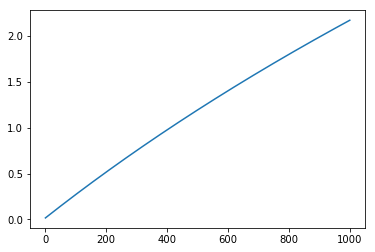

In [105]:
pl.plot(gases['CO2'].effective_radiative_forcing)

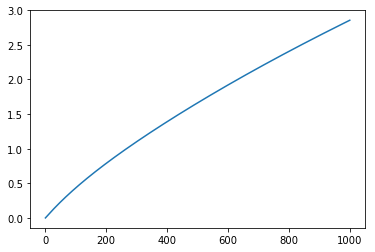

In [106]:
scen.calculate_temperature()
pl.plot(scen.temperature)

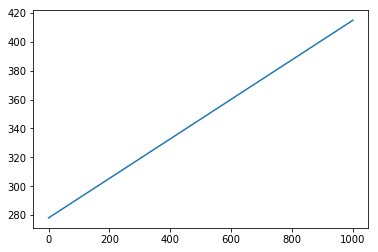

In [107]:
pl.plot(gases['CO2'].concentrations)